In [1]:
import keras 
from keras import layers
from keras import optimizers
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import cv2 as cv

         ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0      id_1       5160     0.000013    120.804174       86.853334   
1      id_2      51980     0.000016    115.318238       83.448681   
2      id_3       2600     0.000010    229.933997      172.761858   
3      id_4       2130     0.000010    369.403342      183.193104   
4      id_5       2310     0.000007    257.997131      111.275889   
..      ...        ...          ...           ...             ...   
169  id_170       2930     0.000010    241.736477      176.115957   
170  id_171       2140     0.000009    274.728964      234.495802   
171  id_172       3830     0.000008    151.536989      171.104693   
172  id_173       1760     0.000008    289.518195      196.411138   
173  id_174       2875     0.000008    235.769350      178.208024   

     max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0                 957              6601          0.361800            0.217459   
1        

NameError: name 'x_train' is not defined

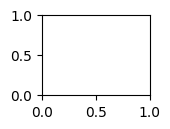

In [20]:
## load the alzheimers dataset
def load_data(show_sample = True):
    
    ## (1) Data preparation
    df=pd.read_csv('AlzData.csv', sep = ',')
    print(df)
    
    #x_test = np.empty((2384, 988, 988))
    
    #for i in range(x_test.shape[0]):
    #    x_test[i] = cv.imread("testImgs/" + str(i) + ".png", 0)
    
    #need to do some sort of zero/same padding to get same image sizes
    # unless using fully convolutional NN bc can take inputs of different sizes
    # or if use a spatial pyramid pooling (SPP) layer before dense layers
    
    #Could possibly create more training data thru upscaling/downscaling
    # would better recognise diff scaled data
    
    # rm ids, rm targets
    transposedDataFrameVals = df.values.T[1:-1]
    #walk thru features
    for i, row in enumerate(transposedDataFrameVals):
        #normalize data [0,1]
        transposedDataFrameVals[i] = row.astype(float) / max(row.astype(float))
    
    #assign normalized data
    X = transposedDataFrameVals.T
    #assign targets
    Y = df.values.T[-1]
        
    #shapes of both are messed up
    
    #store whether benign (0?) or malignant (1?)
    #y_train = 
    #y_test = 
        
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_data()

#print('Data shape:', 'x_train:', x_train.shape, 'x_test:', x_test.shape)
#print('Data shape:', 'y_train:', y_train.shape, 'y_test:', y_test.shape)


In [55]:
# expand dims for channels?

desiredLevels = 2

def CreateConvLayer(convLayers, model, filters, kernel_size, activation = None, padding = "valid"):
    conv = layers.Conv2D(
        filters= filters, #num of filters for conv
        kernel_size = kernel_size, 
        padding = padding,
        activation = activation,
        #input_shape = (28, 28, 1) #only 28 params 
    )
    
    convLayers.append(conv)
    model.add(conv)
    
def CreateMaxPoolLayer(poolLayers, model, pool_size, strides):
    pool = layers.MaxPooling2D(
        pool_size = pool_size,
        strides = strides,
    )
    
    poolLayers.append(pool)
    model.add(pool)
    
def CreateConvBlock(
    model, convLayers, poolLayers, normLayers, activationLayers,
    filters, kernel_size, activation,
    pool_size, strides
):
    CreateConvLayer(convLayers, model, filters, kernel_size)
    #CreateMaxPoolLayer(poolLayers, model, pool_size, strides)
    
    dropout = layers.Dropout(0.2)
    model.add(dropout)
    
    norm = layers.BatchNormalization()
    model.add(norm)
    normLayers.append(norm)

    activ = layers.Activation(activation)
    model.add(activ)
    activationLayers.append(activ)
    
# Create a fully conv NN
model_fcn = keras.Sequential()

convLayers = []
poolLayers = []
normLayers = []
activationLayers = []

# Input layer
input = layers.Input(shape=(None, None, 1))
model_fcn.add(input)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=8, kernel_size=3, activation='relu',
    pool_size=2, strides=2
)

CreateConvBlock(
    model_fcn, convLayers, poolLayers, normLayers, activationLayers,
    filters=16, kernel_size=3, activation='softmax',
    pool_size=2, strides=2
)

globMaxPool = layers.GlobalMaxPooling2D()
model_fcn.add(globMaxPool)

model_fcn(inputs=x_train, outputs=y_train)

#need normalization and output layers

#specify optimization
model_fcn.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_fcn.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, None, None, 8)     80        
                                                                 
 dropout_2 (Dropout)         (None, None, None, 8)     0         
                                                                 
 batch_normalization_2 (Batc  (None, None, None, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, None, None, 8)     0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 dropout_3 (Dropout)         (None, None, None, 16)    0         
                                                      

In [ ]:
#train model
history = model_fcn.fit(
    x_train, #should be 2d inputs
    y_train, #already onehot
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)

In [ ]:
#test accuracy
y_test_pred = model_fcn.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1) #still need to do bc pred is prob?
test_err = np.sum(y_test == y_test_pred) / y_test.shape[0]

print(f'test accuracy: {test_err * 100}')

In [ ]:
#history of training and validation accuracu
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training acc', 'validation acc'])

In [ ]:
#get access to filters/kernels
weights = convLayers[0].get_weights()[0][:, :, 0, :] #arr of a buncha nested lists, 0 bc only have 1 channel (28, 28, 1, 8)

#can get access to other params this way 

for i in range(1, 8):
    plt.subplot(2, 4, i)
    plt.imshow(weights[:,:,i], cmap="gray")
plt.show()

#how get access to feature maps?